In [1]:
# 使わないやつもimportしてると思う
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.font_manager as fm
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import scipy
import seaborn as sns



In [4]:
# CPU Multi
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=8'

import jax
print(jax.default_backend())
print(jax.devices("cpu"))

cpu
[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7)]


In [5]:
import pymc as pm
import arviz as az
print('version.', pm.__version__)

version. 5.8.0


In [11]:
train_df = pd.read_csv('4-1-1-fish-num-2.csv')
train_df['weather_label'] = train_df['weather']=='sunny'
train_df

,fish_num,weather,temperature,id,weather_label
0,0,cloudy,5.0,1,False
1,1,cloudy,24.2,2,False
2,6,cloudy,11.5,3,False
3,0,cloudy,9.8,4,False
4,1,cloudy,18.1,5,False
...,...,...,...,...,...
95,2,sunny,7.5,96,True
96,0,sunny,9.7,97,True
97,0,sunny,9.2,98,True
98,2,sunny,5.5,99,True


In [7]:
train_df.shape

(100, 4)

In [17]:
X_cols = ['weather_label', 'temperature']

# モデルの定義
with pm.Model() as model_poiss:
    # coords(次元やインデックスを定義)
    model_poiss.add_coord('data', values=range(train_df.shape[0]), mutable=True)
    model_poiss.add_coord('var', values=X_cols, mutable=True)

    # 説明変数
    x = pm.MutableData('x', train_df[X_cols].to_numpy(dtype='float32'), dims=('data', 'var'))
    y = pm.MutableData("y", train_df['fish_num'].to_numpy(dtype='float32'), dims=('data', ))

    # 推論パラメータの事前分布
    coef_ = pm.Normal('coef', mu=0.0, sigma=1, dims="var")  # 各係数の事前分布は正規分布
    intercept_ = pm.Normal('intercept', mu=0.0, sigma=1.0)  # 切片の事前分布は正規分布
    r_ = pm.Normal('random', mu=0, sigma=1.0, dims=('data',)) # random効果
    # linear model
    mu = pm.Deterministic("mu", coef_.dot(x.T) + intercept_ + r_, dims=('data', ))
    # link function
    result = pm.Poisson("obs", pm.math.exp(mu), observed=y, dims=('data', ))
    # # likelihood
    # result = pm.Bernoulli("obs", p=link, observed=y, dims=('data', ))

# 定義した各パラメータの情報
display(model_poiss.model)

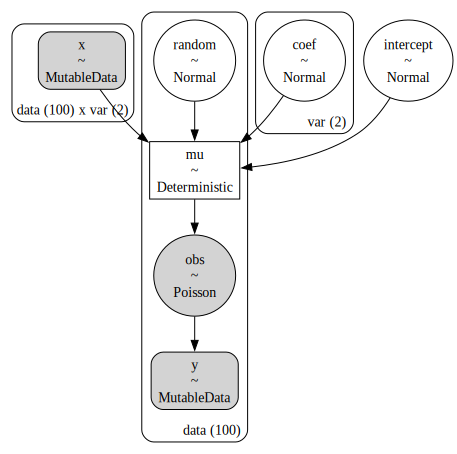

In [18]:
# 構造
modeldag = pm.model_to_graphviz(model_poiss)
display(modeldag)


In [19]:
%%time
# MCMC実行
# バックエンドでNumPyroで実行
with model_poiss:
    # MCMCによる推論
    trace = pm.sample(draws=3000, tune=1000, chains=3, nuts_sampler="numpyro", random_seed=1, return_inferencedata=True)
# >> Wall time: 45.5 s
# データの保存 to_netcdfの利用
# trace.to_netcdf('model_random1.nc')
# データの読み込み from_netcdfの利用
#trace = az.from_netcdf('model_random1.nc')


/Users/tomokazu/miniforge3/envs/pymc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Compiling...
Compilation time =  0:00:04.793211
Sampling...


Compiling.. :   0%|          | 0/4000 [00:00<?, ?it/s]


Running chain 2: 100%|██████████| 4000/4000 [00:01<00:00, 2357.79it/s] 


Sampling time =  0:00:01.972782
Transforming variables...
Transformation time =  0:00:00.077763
CPU times: user 3.32 s, sys: 336 ms, total: 3.65 s
Wall time: 9.64 s


In [23]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

Max rhat: 1.0019636799820377


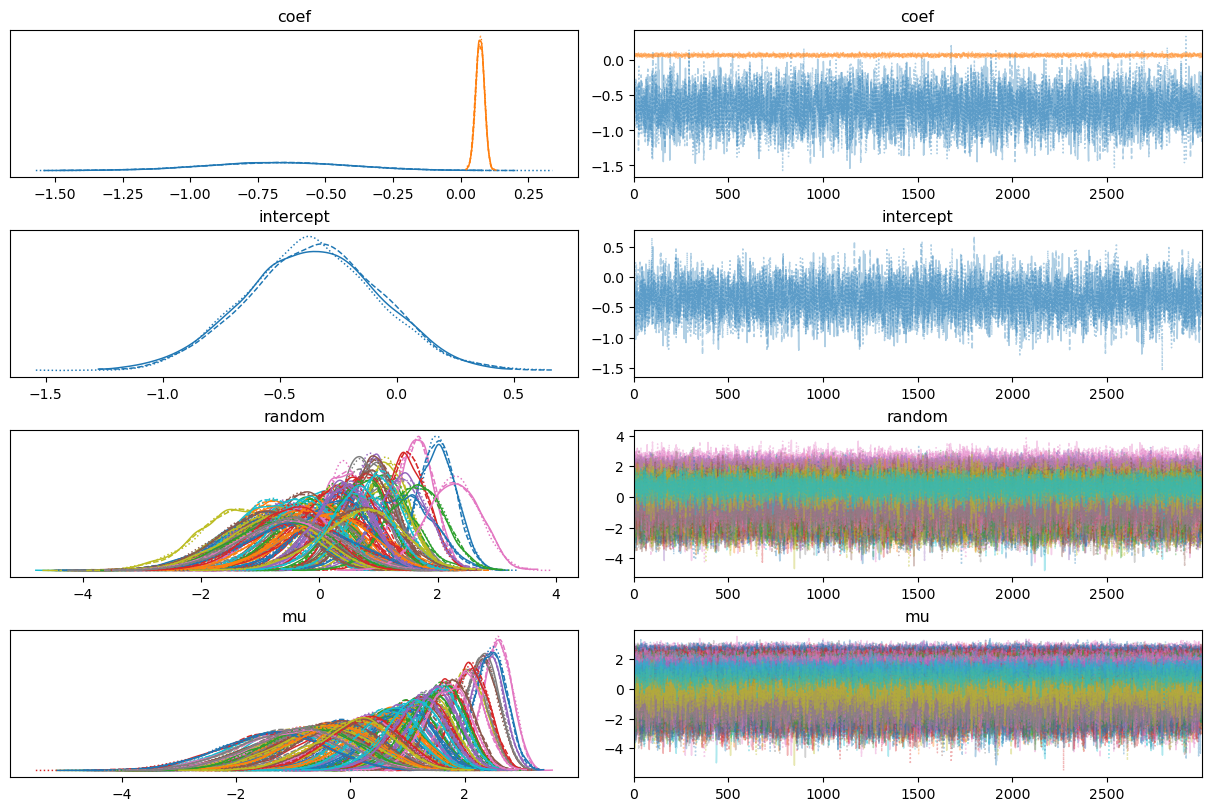

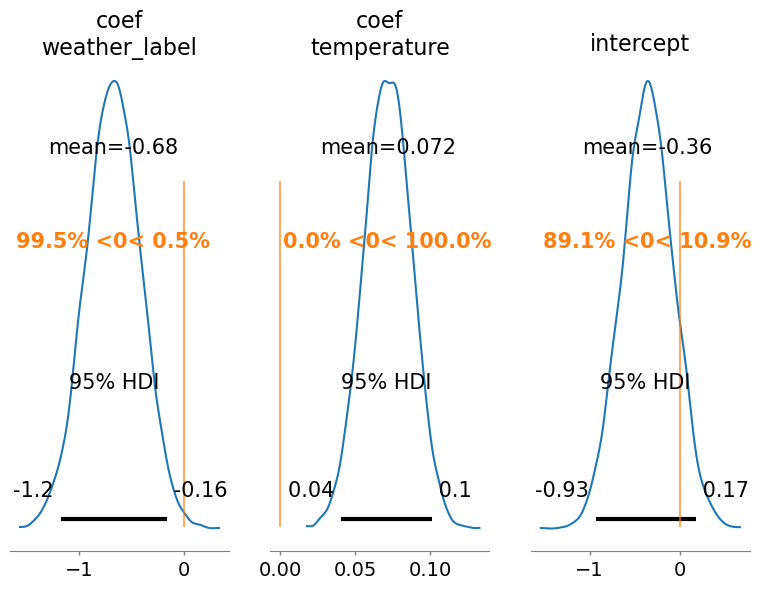

In [30]:
# MCMCの収束を評価
rhat_vals = az.rhat(trace).values()
# 最大のRhatを確認
result = np.max([np.max(i.values) for i in rhat_vals if i.name in ["coef", "intercept", "random", "mu"]])
print('Max rhat:', result)
# 1.1以上のRhatを確認
for i in rhat_vals:
    if np.max(i.values)>=1.1:
        print(i.name, np.max(i.values), np.mean(i.values), i.values.shape, sep='  ====>  ')


# トレースプロットとか
# plot_trace
az.plot_trace(trace, backend_kwargs={"constrained_layout":True}, var_names=["coef", "intercept", "random", 'mu'])
plt.show()

# # forest plotでRハットと一緒に可視化
# az.plot_forest(trace, combined=True, hdi_prob=0.95, r_hat=True, var_names=["coef", "intercept", "random", 'mu'])
# plt.tight_layout()
# plt.show()

# 事後分布の確認
az.plot_posterior(trace, hdi_prob=0.95, var_names=["coef", "intercept"], ref_val=0, figsize=(8,6))
plt.tight_layout()
plt.show()

# # Energy Plot
# az.plot_energy(trace)
# plt.show()
